# **Trustworty AI Homework**
## **Milestone I: Exploratory data analysis**
----------
#### **Student:** Patrik Peter Szmida
#### **Neptun:** G0HPLP
#### **Topic:** Esports analysis - Predicting round winners in Counter Strike
#### **Dataset:** Scraped dataset of Counter Strike matches
----------

In [1]:
from torch_geometric.data import HeteroData, DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

# ---------------------------------------------

class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

## I. Graph data

In [3]:
dataset = torch.load('../model/graph-dataset/semester-1/inferno_graph_dataset.pt')

In [18]:
df_created = False
for graph in dataset:
    if not df_created:
        df = pd.DataFrame(data=graph['player']['x'][:,0:3].numpy(), columns=['x', 'y', 'z'])
        df['roundNum'] = graph['y']['roundNum']
        df['sec'] = graph['y']['sec']
        df['team1AliveNum'] = graph['y']['team1AliveNum']
        df['team2AliveNum'] = graph['y']['team2AliveNum']
        df['CTwinsRound'] = graph['y']['CTwinsRound']
        df_created = True
    else:
        df = pd.concat([df, pd.DataFrame(data=graph['player']['x'][:,0:3].numpy(), columns=['x', 'y', 'z'])])

KeyboardInterrupt: 

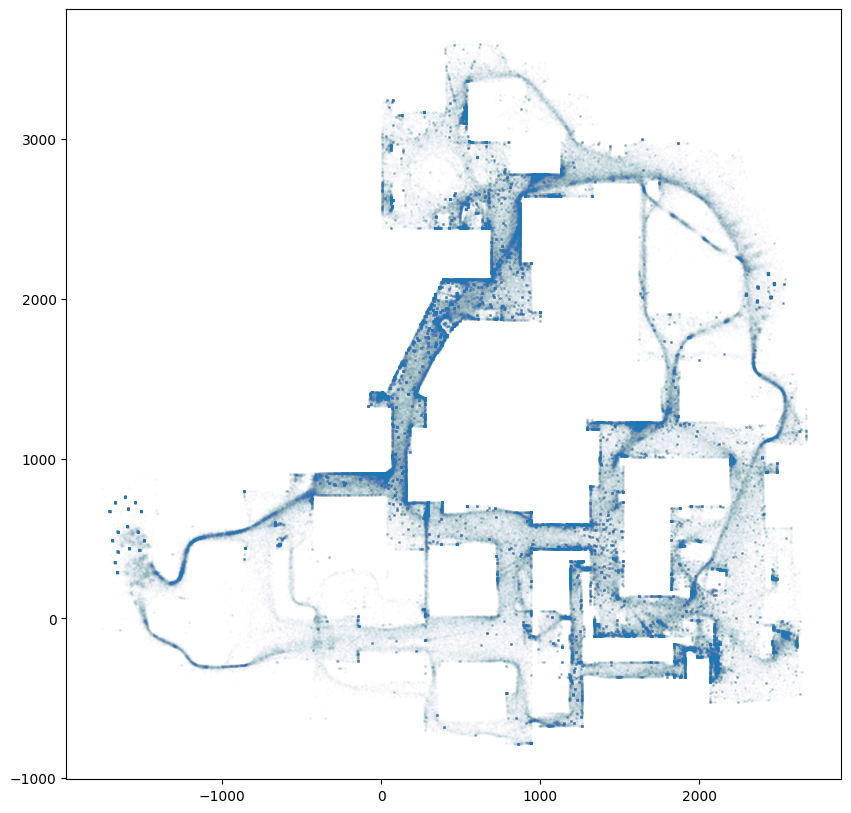

In [14]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df['x'], df['y'], s=0.5, alpha=0.01)
plt.title('')
plt.axis('equal');

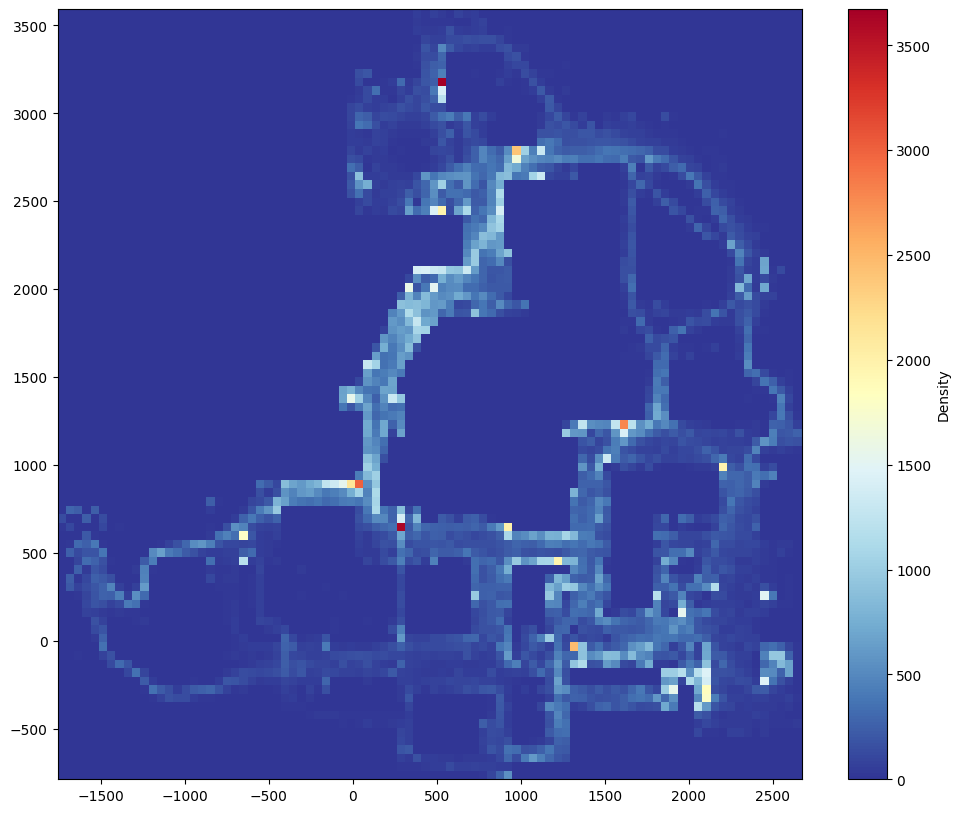

In [12]:
figure = plt.figure(figsize=(12,10))
hb = plt.hist2d(df['x'], df['y'], bins=90,  cmap='RdYlBu_r')
plt.colorbar(hb[3], label='Density')

## II. Player data

In [43]:
def get_names_stats_datasets():
    # Names dataset
    names = pd.read_csv('../data/player-stats/names.csv')
    names['name'] = names['name'].str.replace("NAF-FLY","NAF")
    names['name'] = names['name'].str.replace("niko","niko-")
    names['one'] = 1
    names['count'] = names.groupby(by='name')['one'].transform('sum')
    del names['one']

    # Stats dataset
    stats = pd.read_csv('../data/player-stats/stats.csv')
    stats['player_name'] = stats['player_name'].str.replace("-", "")
    stats['player_name'] = stats['player_name'].str.replace("niko", "niko-")

    return names.drop_duplicates(), stats

names, stats = get_names_stats_datasets()

In [58]:
names.loc[names['name'].str.contains('ee')]

,name,count,one,lowerName,caseDiff
25,oSee,11,1,osee,1
140,dupreeh,8,1,dupreeh,1
414,saffee,10,1,saffee,1


In [62]:
dropArr = [475, 539, 216, 256, 462, 543, 734, 361, 652]
stats.loc[stats.index.isin(dropArr)]

,player_name,rating_2.0,DPR,KAST,Impact,ADR,KPR,total_kills,HS%,total_deaths,...,weapon_data,clutches_won_1on1,clutches_lost_1on1,clutches_won_1on2,clutches_won_1on3,clutches_won_1on4,clutches_won_1on5,one,lowerName,caseDiff
216,Lucky,1.08,0.63,70.0,1.07,71.8,0.70,7565,40.7,6846,...,"{'kills_awp': '3362', 'kills_ak47': '1341', 'k...",79,67,50,16,1,0,1,lucky,2
256,Lucky,1.10,0.64,71.7,1.07,77.2,0.69,20018,41.6,18516,...,"{'kills_ak47': '6827', 'kills_m4a1': '2724', '...",207,150,110,22,6,0,1,lucky,2
361,steel,1.02,0.69,69.6,1.16,80.0,0.71,11498,45.7,11237,...,"{'kills_ak47': '3258', 'kills_m4a1': '1356', '...",121,68,60,11,2,0,1,steel,2
462,adreN,1.00,0.65,70.9,1.02,76.5,0.67,12259,35.3,11879,...,"{'kills_ak47': '3892', 'kills_awp': '2891', 'k...",150,98,78,22,4,0,1,adren,2
475,ALEX,1.00,0.71,67.5,1.10,76.5,0.70,20286,47.5,20558,...,"{'kills_ak47': '7076', 'kills_m4a1': '3701', '...",173,99,71,19,5,0,1,alex,2
539,AdreN,0.98,0.68,68.5,1.05,75.9,0.67,31342,48.9,31562,...,"{'kills_ak47': '11917', 'kills_m4a1': '5093', ...",282,184,147,38,6,0,1,adren,2
543,roman,0.98,0.69,70.3,1.04,74.1,0.68,17857,54.2,17998,...,"{'kills_ak47': '7757', 'kills_m4a1': '2437', '...",149,142,99,20,3,0,1,roman,2
652,steel,0.95,0.67,70.0,0.97,71.9,0.65,23900,40.8,24692,...,"{'kills_ak47': '9114', 'kills_m4a1': '5601', '...",234,156,122,25,1,1,1,steel,2
734,roman,0.91,0.68,68.3,0.89,69.6,0.62,6787,55.0,7451,...,"{'kills_ak47': '2418', 'kills_m4a1': '1478', '...",77,74,33,10,1,0,1,roman,2


In [54]:
df = names.merge(stats, how='left', left_on='name', right_on='player_name')
df.loc[df['rating_2.0'].isna()].head(20)

,name,count,player_name,rating_2.0,DPR,KAST,Impact,ADR,KPR,total_kills,...,rating_1.0_lan_Career,rating_1.0_major_Career,rating_1.0_data,weapon_data,clutches_won_1on1,clutches_lost_1on1,clutches_won_1on2,clutches_won_1on3,clutches_won_1on4,clutches_won_1on5
4,m0NESY,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,jeorge,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,headtr1ck,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NAF-FLY,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,regali,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,s1n,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,Krimbo,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,prosus,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,jL,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,dev1ce,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
